# Simple example of calculating matrix elements

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
from pairinteraction import pireal as pi

from numerov.matrix_elements import radial_matrix_element
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.ERROR)  # disable xmin warnings for now

In [2]:
dn, dl, dj, dm = (3, 1, 0, 0)
# dn, dl, dj, dm = (5, 1, 0, 0)
# dn, dl, dj, dm = (5, 2, 1, 0)
# qn_list: (n, l, j, mj)
qn1_list = np.array([(n1, n1 - 1, n1 - 0.5, n1 - 0.5) for n1 in range(20, 150)])
qn2_list = np.array([(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list])

In [3]:
matrixelements = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("Rb", qn1[0], qn1[1], qn1[2], dz=0.001)
    state_f = RydbergState("Rb", qn2[0], qn2[1], qn2[2], dz=0.001)
    state_i.integrate()
    state_f.integrate()
    matrixelements.append(np.abs(radial_matrix_element(state_i, state_f, 1)))

matrixelements = np.array(matrixelements)

In [4]:
os.makedirs("./.pairinteraction_cache/", exist_ok=True)
cache = pi.MatrixElementCache("./.pairinteraction_cache/")
cache.setMethod(pi.NUMEROV)  # pi.NUMEROV or pi.WHITTAKER

matrixelements_pi = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
    state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
    matrixelements_pi.append(np.abs(cache.getRadial(state_f, state_i, 1)))

matrixelements_pi = np.array(matrixelements_pi)

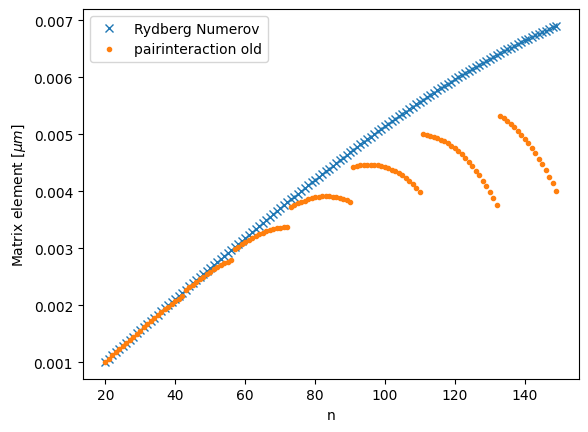

In [5]:
y = matrixelements * ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude
y_pi = matrixelements_pi
n_list = qn1_list[:, 0]

fig, ax = plt.subplots()
ax.plot(n_list, y, "C0x", label="Rydberg Numerov")
ax.plot(n_list, y_pi, "C1.", label="pairinteraction old")
ax.set_xlabel("n")
ax.set_ylabel(r"Matrix element [$\mu m$]")
ax.legend()
plt.show()